<a href="https://colab.research.google.com/github/kimyoungjoune/anything/blob/main/DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('bmh')
import numpy as np

from datetime import datetime, timedelta

from dateutil.relativedelta import relativedelta #relativedelta(month = ) 사용 가능

     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 44.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
def dual_momentum(data, rf_column_name, index_column_name, last_period = 12):
    """ 듀얼 모멘텀에 따른 의사결정을 padasDF 로 반환하는 함수
        data : pandas DF (원 가격 데이터 - 수익률 X ) 
        rf_column_name : str -> ex) 채권 AGG
        index_column_name : str -> ex) S&P
        last period : int (지난 몇 달간의 데이터를 바탕으로 의사결정을 할 것인가)"""
    return_data = data.pct_change().dropna().resample('D').first().fillna(0)
    #riskey_assets = return_data.drop(rf_column_name, axis=1)
    #rf_asset = return_data[[rf_column_name]]
    
    
    start_date = return_data.index[0] + relativedelta(months = last_period)
    
    positions = pd.DataFrame(columns = ["choice"], index = return_data.loc[start_date:].index)

    for date in return_data.loc[start_date:].index:
        last_preiod_df = return_data[date - relativedelta(months = last_period) : date]
        period_return = (last_preiod_df+1).prod()-1
        # 절대 모멘텀 연산 
        if period_return[rf_column_name] > period_return[index_column_name] :
            positions["choice"].loc[date] = rf_column_name
        else :
            #상대 모멘텀 연산
            positions["choice"].loc[date] = period_return.idxmax()
    return  positions

def real_rtn_rate(data, investment_period = 1): #index 가 투자 끝나는 날
    """
    해당 날짜에 investment_period (months)만큼 투자했을 경우 끝나는 날과, 그 기간동안의 수익률
    data : pandas DF (원 가격 데이터 - 수익률 X ) 
    investment_period : int (투자 기간 월단위)
    """
    return_data = data.pct_change().dropna().resample('D').first().fillna(0)
    df_start_date = return_data.index[0] + relativedelta(months=investment_period)
    df_end_date = return_data.index[-1] 
    real_return = pd.DataFrame(columns =  (list(return_data.columns)) + ["start_date"], index = return_data.loc[ df_start_date : df_end_date].index)
    for date in real_return.index:
        start_date = date - relativedelta(months = investment_period)
        period_df = return_data[ start_date :  date ]
        period_return = (period_df+1).prod()-1
        period_return.loc["start_date"] = start_date
        real_return.loc[date] = period_return
    return real_return

def calcurate_return (dual_momentum1,  real_rtn_rate1, investment_period = 1):
    """
    dual_momentum결과이지만, 선정된 포트폴리오 이름만 담기면 됨.

    """
    start_date = dual_momentum1.index[0]
    end_date = real_rtn_rate1.index[-1]

    result_return = pd.DataFrame(columns = ["portfolio"], index = pd.date_range(start= start_date + relativedelta(months=investment_period) , end= end_date))

    for date in result_return.index:
        choice = dual_momentum1.loc[date - relativedelta(months=investment_period)]["choice"]
        result_return.loc[date]["portfolio"] = real_rtn_rate1.loc[date][choice]
    return result_return

# 즉시 실행

In [ ]:
무위험자산이름 = "AGG"
#iShares Core U.S. Aggregate Bond ETF Sharpe ratio is -1.59.
기준지수 = "^GSPC"
#prices = yf.download(["^GSPC", "^DJI","^N225",   "^HSI", "^KS11", "AGG"])["Adj Close"].fillna(method='ffill')
prices = yf.download(["^GSPC", "^DJI","^N225",   "^IXIC", "^HSI","^MXX", "^KS11", "AGG"])["Adj Close"].fillna(method='ffill')
#prices.pct_change().dropna()
기간1 = 6 #의사결정시 몇월 전 데이터 까지 볼 것인가
기간2 = 3 #의사 결정을 몇 개월마다 할 것인가.


[*********************100%***********************]  8 of 8 completed


75
portfolio    0.207112
AGG          0.242201
^DJI         0.163240
^GSPC        0.169279
^HSI         0.077638
^IXIC        0.203508
^KS11        0.117215
^MXX         0.157199
^N225        0.090996
dtype: float64


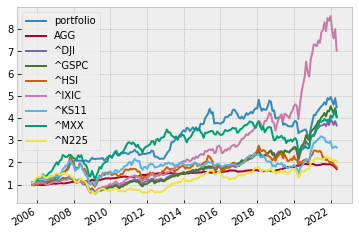

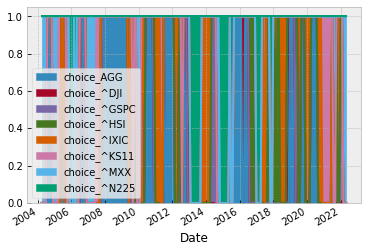

In [ ]:
기간1 = 6 #의사결정시 몇월 전 데이터 까지 볼 것인가
기간2 = 1 #의사 결정을 몇 개월마다 할 것인가.

dual_momentum_result = dual_momentum(prices, 무위험자산이름, 기준지수, last_period = 기간1)
return_of_assets = real_rtn_rate(prices, investment_period = 기간2)
return_of_portfolio = calcurate_return(dual_momentum_result,return_of_assets, investment_period = 기간2)    
full_df = pd.concat([return_of_portfolio, return_of_assets], axis = 1).dropna()
full_df

query_day = 2
monthly_return_data = full_df.query('index.dt.day == @query_day')

#시간 고정 portfolio 제외  동일한 sharpratio 확인용 지워도 됨
monthly_return_data = monthly_return_data.loc["2005-10-02":]


(monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod() #월간 수익률 누적곱
(monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod().plot()

monthly_choice_data = dual_momentum_result.query('index.dt.day == @query_day')
pd.get_dummies(monthly_choice_data).plot.area()


print(len(monthly_choice_data [monthly_choice_data ['choice'] != monthly_choice_data ['choice'].shift(-1)])) # 기간 내에 총 자산 변경 횟수
print((monthly_return_data[monthly_return_data.columns[:-1]]).mean() / (monthly_return_data[monthly_return_data.columns[:-1]]).std()) #sharp ratio 

57
portfolio    0.256674
AGG          0.242201
^DJI         0.163240
^GSPC        0.169279
^HSI         0.077638
^IXIC        0.203508
^KS11        0.117215
^MXX         0.157199
^N225        0.090996
dtype: float64


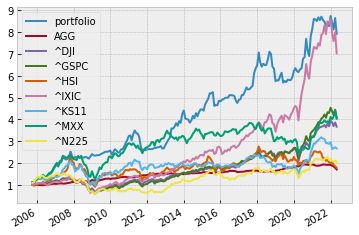

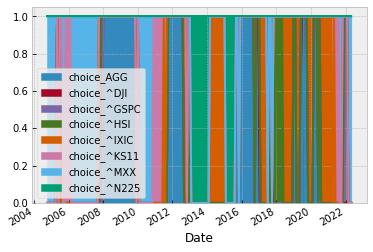

In [ ]:
기간1 = 12 #의사결정시 몇월 전 데이터 까지 볼 것인가
기간2 = 1 #의사 결정을 몇 개월마다 할 것인가.

dual_momentum_result = dual_momentum(prices, 무위험자산이름, 기준지수, last_period = 기간1)
return_of_assets = real_rtn_rate(prices, investment_period = 기간2)
return_of_portfolio = calcurate_return(dual_momentum_result,return_of_assets, investment_period = 기간2)    
full_df = pd.concat([return_of_portfolio, return_of_assets], axis = 1).dropna()
full_df

#매월 2일 데이터만 가져오기
query_day = 2
monthly_return_data = full_df.query('index.dt.day == @query_day')

#시간 고정 portfolio 제외  동일한 sharpratio 확인용 지워도 됨
monthly_return_data = monthly_return_data.loc["2005-10-02":]


(monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod() #월간 수익률 누적곱
(monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod().plot()

monthly_choice_data = dual_momentum_result.query('index.dt.day == @query_day')
pd.get_dummies(monthly_choice_data).plot.area()


print(len(monthly_choice_data [monthly_choice_data ['choice'] != monthly_choice_data ['choice'].shift(-1)])) # 기간 내에 총 자산 변경 횟수
print((monthly_return_data[monthly_return_data.columns[:-1]]).mean() / (monthly_return_data[monthly_return_data.columns[:-1]]).std()) #sharp ratio 

45
portfolio    0.335639
AGG          0.544411
^DJI         0.292667
^GSPC        0.307926
^HSI         0.125791
^IXIC        0.356317
^KS11        0.229873
^MXX         0.304408
^N225        0.165078
dtype: float64


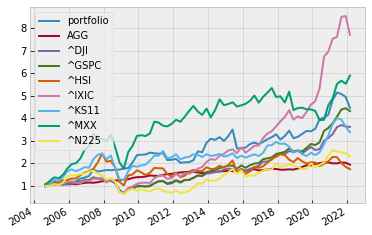

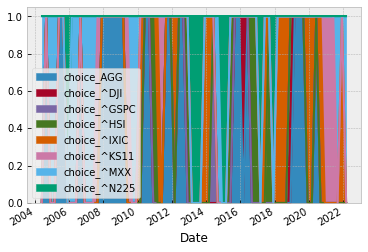

In [ ]:
기간1 = 6 #의사결정시 몇월 전 데이터 까지 볼 것인가
기간2 = 3 #의사 결정을 몇 개월마다 할 것인가.

dual_momentum_result = dual_momentum(prices, 무위험자산이름, 기준지수, last_period = 기간1)
return_of_assets = real_rtn_rate(prices, investment_period = 기간2)
return_of_portfolio = calcurate_return(dual_momentum_result,return_of_assets, investment_period = 기간2)    
full_df = pd.concat([return_of_portfolio, return_of_assets], axis = 1).dropna()
full_df

query_day = 2
query_month = 3
month3_return_data = full_df.query('index.dt.day == @query_day')
month3_return_data = month3_return_data.query('index.dt.month %3 == 0')

month3_return_data 
(month3_return_data[month3_return_data.columns[:-1]]+1).cumprod() #월간 수익률 누적곱
(month3_return_data[month3_return_data.columns[:-1]]+1).cumprod().plot()
#(month3_return_data[month3_return_data.columns[:-1]]+1).cumprod().mean() / (month3_return_data[month3_return_data.columns[:-1]]+1).cumprod().mean().std()


# 시간 설정용 3달마다 1번 이루어지므로, 3달에 한번 데이터를 뽑아내는 문장이 추가됨
month3_choice_data = dual_momentum_result.query('index.dt.day == @query_day')
month3_choice_data = month3_choice_data.query('index.dt.month %3 == 0')
pd.get_dummies(month3_choice_data).plot.area()



print(len(month3_choice_data [month3_choice_data ['choice'] != month3_choice_data ['choice'].shift(-1)])) # 기간 내에 총 자산 변경 횟수

print((month3_return_data[month3_return_data.columns[:-1]]).mean() / (month3_return_data[month3_return_data.columns[:-1]]).std()) #sharp ratio 


# 데이터 수집

In [ ]:
prices = yf.download(["SPY", "ACWX", "AGG", "ACWI"])["Adj Close"].fillna(method='ffill')
prices.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


,ACWI,ACWX,AGG,SPY
Date,,,,
2008-04-02,0.011056,0.009736,0.000492,0.000659
2008-04-03,0.005663,0.008870,0.003149,0.002487
2008-04-04,-0.000583,0.002485,0.005100,-0.001095
2008-04-07,0.005829,0.004957,-0.000097,0.000511
2008-04-08,0.006181,-0.004743,-0.000097,-0.001022
...,...,...,...,...
2022-05-16,-0.003253,0.000846,0.002244,-0.004058
2022-05-17,0.020259,0.020072,-0.005451,0.020570
2022-05-18,-0.033425,-0.023612,0.004012,-0.040312


In [ ]:
timedelta()

datetime.timedelta(0)

# dual_momentum 결정

In [ ]:
def dual_momentum(data, rf_column_name, last_period = 12):
    """ 듀얼 모멘텀에 따른 의사결정을 padasDF 로 반환하는 함수
        data : pandas DF (원 가격 데이터 - 수익률 X ) 
        rf_column_name : str
        last period : int (지난 몇 달간의 데이터를 바탕으로 의사결정을 할 것인가)"""
    return_data = data.pct_change().dropna().resample('D').first().fillna(0)
    #riskey_assets = return_data.drop(rf_column_name, axis=1)
    #rf_asset = return_data[[rf_column_name]]
    
    
    start_date = return_data.index[0] + relativedelta(months = last_period)
    
    positions = pd.DataFrame(columns = ["choice"], index = return_data.loc[start_date:].index)

    for date in return_data.loc[start_date:].index:
        last_preiod_df = return_data[date - relativedelta(months = last_period) : date]
        period_return = (last_preiod_df+1).prod()-1
        # 절대 모멘텀 연산 
        if period_return.idxmax() == rf_column_name:
            positions["choice"].loc[date] = rf_column_name
        else :
            #상대 모멘텀 연산
            positions["choice"].loc[date] = period_return.idxmax()
    return  positions

In [ ]:
dual_momentum(prices, 'AGG', last_period = 12)

# 자산별 투자 했을 때 1달간 월간 수익률 반환

In [ ]:
def real_rtn_rate2(data, investment_period = 1): #index 가 투자 시직하는 날
    """
    해당 날짜에 investment_period (months)만큼 투자했을 경우 끝나는 날과, 그 기간동안의 수익률
    data : pandas DF (원 가격 데이터 - 수익률 X ) 
    investment_period : int (투자 기간 월단위)
    """
    return_data = data.pct_change().dropna().resample('D').first().fillna(0)


    end_date = return_data.index[-1] - relativedelta(months = investment_period)
    real_return = pd.DataFrame(columns =  (list(return_data.columns)) +["end_date"], index = return_data.loc[:end_date].index)
        

    for date in return_data.loc[:end_date].index:
        end_date = date + relativedelta(months = investment_period)
        period_df = return_data[date :  end_date ]
        period_return = (period_df+1).prod()-1
        period_return.loc["end_date"] = end_date
        real_return.loc[date] = period_return
    
    return real_return


In [ ]:
def real_rtn_rate(data, investment_period = 1): #index 가 투자 끝나는 날
    """
    해당 날짜에 investment_period (months)만큼 투자했을 경우 끝나는 날과, 그 기간동안의 수익률
    data : pandas DF (원 가격 데이터 - 수익률 X ) 
    investment_period : int (투자 기간 월단위)
    """
    return_data = data.pct_change().dropna().resample('D').first().fillna(0)

    df_start_date = return_data.index[0] + relativedelta(months=investment_period)
    df_end_date = return_data.index[-1] 
    
    real_return = pd.DataFrame(columns =  (list(return_data.columns)) + ["start_date"], index = return_data.loc[ df_start_date : df_end_date].index)
    

    for date in real_return.index:
        
        start_date = date - relativedelta(months = investment_period)
        
        period_df = return_data[ start_date :  date ]
        
        period_return = (period_df+1).prod()-1
        
        period_return.loc["start_date"] = start_date
        
        real_return.loc[date] = period_return
    
    return real_return

In [ ]:
real_rtn_rate(prices, investment_period = 1)

# 전략에 따른 수익률

In [ ]:
def calcurate_return (dual_momentum1,  real_rtn_rate1, investment_period = 1):
    """
    dual_momentum결과이지만, 선정된 포트폴리오 이름만 담기면 됨.

    """
    start_date = dual_momentum1.index[0]
    end_date = real_rtn_rate1.index[-1]
    investment_period = 1

    result_return = pd.DataFrame(columns = ["portfolio"], index = pd.date_range(start= start_date + relativedelta(months=investment_period) , end= end_date))

    for date in result_return.index:
        choice = dual_momentum1.loc[date - relativedelta(months=investment_period)]["choice"]
        result_return.loc[date]["portfolio"] = real_rtn_rate1.loc[date][choice]
    return result_return

In [ ]:
return_of_portfolio = calcurate_return(dual_momentum(prices, 'AGG', last_period = 6),real_rtn_rate(prices, investment_period = 1), 1)       

In [ ]:
# 전체 데이터
return_of_portfolio

# 시각화

In [ ]:
return_of_assets = real_rtn_rate(prices, investment_period = 1)

In [ ]:
full_df = pd.concat([return_of_portfolio, return_of_assets], axis = 1).dropna()
full_df

In [ ]:
# 위에서 보면 날짜별로 계산되어 있지만, 날짜별 월간 수익률이 계산되어 있습니다. 즉 월간 1번 씩만 선택해야할 필요가 있습니다 . 이 코드는 다음과 같습니다.
# 현태 코드는 매월 2일로 되어 있으며 변경은 가능합니다.
query_day = 2
monthly_return_data = full_df.query('index.dt.day == @query_day')
monthly_return_data 

In [ ]:
(monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod() #월간 수익률 누적곱

In [ ]:
(monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod().plot()

In [ ]:
pd.get_dummies(dual_momentum(prices, 'AGG', last_period = 12)).plot.area()

In [ ]:
(monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod().mean() / (monthly_return_data[monthly_return_data.columns[:-1]]+1).cumprod().mean().std()

# 참고용

In [ ]:
prices = yf.download(["SPY", "ACWX", "AGG", "ACWI"])["Adj Close"].dropna()
acwi = prices["ACWI"].pct_change().dropna()
prices.drop("ACWI", axis=1, inplace=True)
risky_assets_ret = prices.drop("AGG", axis=1).pct_change().dropna()

bond = prices["AGG"].pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


In [ ]:
def dual_mom(lookback, rebalancing_frequency):
    positions = pd.Series()
    for i in range(lookback, len(risky_assets_ret), rebalancing_frequency):
        date = risky_assets_ret.index[i]

        total_return = (risky_assets_ret.iloc[i-lookback:i] + 1).prod() - 1
        if total_return.max() < 0:
            positions.loc[date] = "AGG"
        else:
            positions.loc[date] = total_return.idxmax()
    positions = pd.get_dummies(positions).reindex(risky_assets_ret.index).ffill().dropna()
    ports_ret = pd.concat([risky_assets_ret, bond], axis=1).iloc[lookback:]
    ports_ret["Dual Momentum"] = ports_ret.multiply(positions, axis=1).sum(axis=1)
    return positions, ports_ret

def annualized_returns(returns, num_periods_year):
    return (returns + 1).prod() ** (num_periods_year/len(returns)) - 1

def sharpe_ratio(returns, rf = 0.015, num_periods_year=252):
    avg_ret = annualized_returns(returns, num_periods_year)
    std = returns.std() * 252 ** 0.5
    return (avg_ret - rf) / std


def get_drawdowns(returns):
    """
    Reports the drawdawns from the all time high
    """
    cumil_rets = (returns + 1).cumprod()
    cumil_max = cumil_rets.cummax()
    percent_diff = cumil_rets / cumil_max - 1
    return percent_diff

In [ ]:
positions, ports_ret = dual_mom(lookback=12*21, rebalancing_frequency=21*1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
positions

,ACWX,AGG,SPY
Date,,,
2009-04-01,0.0,1.0,0.0
2009-04-02,0.0,1.0,0.0
2009-04-03,0.0,1.0,0.0
2009-04-06,0.0,1.0,0.0
2009-04-07,0.0,1.0,0.0
...,...,...,...
2022-05-16,0.0,0.0,1.0
2022-05-17,0.0,0.0,1.0
2022-05-18,0.0,0.0,1.0


In [ ]:
ports_ret["70% ACWI, 30% AGG"] = acwi * .7 + ports_ret["AGG"] * .3

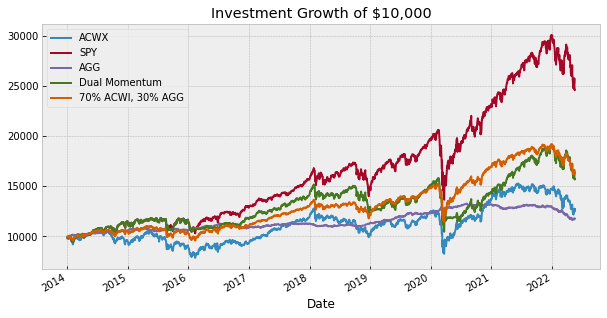

In [ ]:
((ports_ret["2014-01-01":] + 1).cumprod() * 10000).plot(figsize=(10, 5), title="Investment Growth of $10,000")

In [ ]:
oos_ports_ret = ports_ret["2014-01-01":]
back_test_results = pd.DataFrame()
back_test_results["Return"] = annualized_returns(oos_ports_ret, 252) * 100
back_test_results["Volatility"] = oos_ports_ret.std() * 252 ** 0.5 * 100
back_test_results["Sharpe Ratio"] = sharpe_ratio(oos_ports_ret)
back_test_results["Maximum Drawdowns"] = get_drawdowns(oos_ports_ret).min() * 100
back_test_results = back_test_results.round(2)

In [ ]:
back_test_results.to_clipboard()

PyperclipException: ignored

In [ ]:
dual_momentum1 = dual_momentum(prices, 'AGG', last_period = 12)
real_rtn_rate1 = real_rtn_rate(prices, investment_period = 1)

In [ ]:
start_date = dual_momentum1.index[0]
end_date = real_rtn_rate1.index[-1]
investment_period = 1

result_return = pd.DataFrame(columns = ["return"], index = pd.date_range(start= start_date + relativedelta(months=investment_period) , end= end_date))

for date in result_return.index:
    choice = dual_momentum1.loc[date - relativedelta(months=investment_period)]["choice"]
    result_return.loc[date]["return"] = real_rtn_rate1.loc[date][choice]

In [ ]:
result_return

,return
2009-05-02,0.001759
2009-05-03,0.00494
2009-05-04,0.009042
2009-05-05,0.01114
2009-05-06,0.013437
...,...
2022-05-16,-0.086114
2022-05-17,-0.067315
2022-05-18,-0.104913
2022-05-19,-0.110761


In [ ]:
real_rtn_rate1.loc[date - relativedelta(months=investment_period)][choice]

0.001758539703329065

In [ ]:
result_return.loc[data]["return"]

ValueError: ignored

ValueError: ignored

In [ ]:
investment_period = 1
data = prices
return_data = data.pct_change().dropna().resample('D').first().fillna(0)


end_date = return_data.index[-1] - relativedelta(months = investment_period)
real_return = pd.DataFrame(columns =  (list(return_data.columns)) +["end_date"], index = return_data.loc[:end_date].index)
    

for date in return_data.loc[:end_date].index:
    end_date = date + relativedelta(months = investment_period)
    period_df = return_data[date :  end_date ]
    period_return = (period_df+1).prod()-1
    period_return.loc["end_date"] = end_date
    real_return.loc[date] = period_return
real_return

,ACWI,ACWX,AGG,SPY,end_date
Date,,,,,
2008-04-02,0.054689,0.054517,0.006743,0.035869,2008-05-02 00:00:00
2008-04-03,0.043156,0.04435,0.006247,0.035187,2008-05-03 00:00:00
2008-04-04,0.037281,0.035168,0.003088,0.032618,2008-05-04 00:00:00
2008-04-05,0.0408,0.040991,-0.001611,0.028782,2008-05-05 00:00:00
2008-04-06,0.047795,0.048999,-0.004842,0.037695,2008-05-06 00:00:00
...,...,...,...,...,...
2022-04-16,-0.085058,-0.075405,-0.010089,-0.086114,2022-05-16 00:00:00
2022-04-17,-0.066522,-0.056847,-0.015484,-0.067315,2022-05-17 00:00:00
2022-04-18,-0.097724,-0.079117,-0.011534,-0.104913,2022-05-18 00:00:00


In [ ]:
print(["end_date"] + (list(return_data.columns)))

['end_date', 'ACWI', 'ACWX', 'AGG', 'SPY']


In [ ]:
period_return.loc["end_date"] = end_date
period_return

ACWI                  -0.025064
ACWX                   -0.10156
AGG                    0.096595
SPY                    0.036017
end_date    2022-04-20 00:00:00
dtype: object

In [ ]:
test = pd.DataFrame(columns= pd.DataFrame(period_return).T.columns, index = return_data.loc[start_date:].index)
test.loc[test.index[0]] = period_return
test

,ACWI,ACWX,AGG,SPY
Date,,,,
2009-04-02,-0.025064,-0.10156,0.096595,0.036017
2009-04-03,NaN,NaN,NaN,NaN
2009-04-04,NaN,NaN,NaN,NaN
2009-04-05,NaN,NaN,NaN,NaN
2009-04-06,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-05-16,NaN,NaN,NaN,NaN
2022-05-17,NaN,NaN,NaN,NaN
2022-05-18,NaN,NaN,NaN,NaN


In [ ]:
data = prices
rf_column_name = 'AGG'
last_period = 12

return_data = data.pct_change().dropna().resample('D').first().fillna(0)
return_data
riskey_assets = return_data.drop(rf_column_name, axis=1)
rf_asset = return_data[[rf_column_name]]



start_date = return_data.index[0] + relativedelta(months = last_period)

position = pd.DataFrame(columns = ["choice"],index = return_data.loc[start_date:].index)

for date in return_data.loc[start_date:].index:
    last_preiod_df = return_data[date - relativedelta(months = last_period) : date]
    period_return = (last_preiod_df+1).prod()-1
    # 절대 모멘텀 연산 
    if period_return.idxmax() == rf_column_name:
        position["choice"].loc[date] = rf_column_name

position # 어디에 투자하는지

,choice
Date,
2009-04-02,AGG
2009-04-03,AGG
2009-04-04,AGG
2009-04-05,AGG
2009-04-06,AGG
...,...
2022-05-16,NaN
2022-05-17,NaN
2022-05-18,NaN


In [ ]:
riskey_assets = last_preiod_df.drop(rf_column_name, axis=1)
rf_asset = last_preiod_df[[rf_column_name]]
rf_rate = (rf_asset+1).prod()
riskey_assets_rate = (riskey_assets+1).prod()
riskey_assets_rate.idxmax()

'SPY'

In [ ]:
last_preiod_df = return_data[date - relativedelta(months = last_period) : date]
period_return = (last_preiod_df+1).prod()-1
#period_return.to_dict()
sorted2 = dict(sorted(period_return.to_dict().items(), key=lambda x: x[1]))
sorted2

{'ACWI': -0.09362466340699505,
 'ACWX': -0.1370262193858094,
 'AGG': -0.07930016142434493,
 'SPY': -0.04513547890706615}

In [ ]:
period_return.to_dict()

{'ACWI': -0.09362466340699505,
 'ACWX': -0.1370262193858094,
 'AGG': -0.07930016142434493,
 'SPY': -0.04513547890706615}

In [ ]:
pd.DataFrame(period_return).T

,ACWI,ACWX,AGG,SPY
0,0.906375,0.862974,0.9207,0.954865
